## Self-Supervised Style Transfer for Image Representation Learning
\\
Eda Selin Küçükkara 150210325 \\
Revna Altınöz 150220756 \\
Alperen Çağlar 150210340

In [ ]:
%pip install fiftyone
!pip install git+https://github.com/asahi417/wikiart-image-dataset

  Cloning https://github.com/asahi417/wikiart-image-dataset to /tmp/pip-req-build-7gcrr_eb
  Running command git clone --filter=blob:none --quiet https://github.com/asahi417/wikiart-image-dataset /tmp/pip-req-build-7gcrr_eb
  Resolved https://github.com/asahi417/wikiart-image-dataset to commit 3e3d7cf99d048af0a815a69303d10d473508c92e
  Preparing metadata (setup.py) ... done


In [ ]:
from PIL import Image

import fiftyone as fo
import fiftyone.zoo as foz
from wikiartcrawler import WikiartAPI
from wikiartcrawler import artist_group
from wikiartcrawler import artist_group
from wikiartcrawler import WikiartAPI, get_artist

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import re
import urllib.parse

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

import numpy as np
from sklearn.model_selection import train_test_split

from io import BytesIO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


['3d', 'a-y-jackson', 'aaron-douglas', 'aaron-siskind', 'abanindranath-tagore', 'abbas-kiarostami', 'abdul-mati-klarwein', 'abdul-qader-al-raes', 'abdullah-suriosubroto', 'abidin-dino', 'abraham-palatnik', 'abraham-storck', 'abraham-van-strij', 'absalon', 'abu-faisal', 'achille-beltrame', 'achille-dorsi', 'ad-reinhardt', 'adalbert-erdeli', 'adalbert-schaffer', 'adam-baltatu', 'adam-van-der-meulen', 'adam-van-noort', 'adja-yunkers', 'adolf-dietrich', 'adolf-fleischmann', 'adolf-wolfli', 'adolph-de-meyer', 'adolphe-joseph-thomas-monticelli', 'adriaen-van-de-venne', 'adrian-piper', 'adrien-dax', 'aelbert-cuyp', 'afewerk-tekle', 'agim-sulaj', 'agnes-goodsir', 'agnolo-bronzino', 'agostino-bonalumi', 'agostino-carracci', 'agostino-tassi', 'agustin-cardenas', 'ahmad-musa', 'ahmed-karahisari', 'ai-weiwei', 'aki-kuroda', 'akkitham-narayanan', 'akseli-gallen-kallela', 'al-held', 'al-jazari', 'aladar-korosfoi-kriesch', 'alan-aine', 'alan-lee', 'alan-stephens-foster', 'alan-tellez', 'albert-anker'

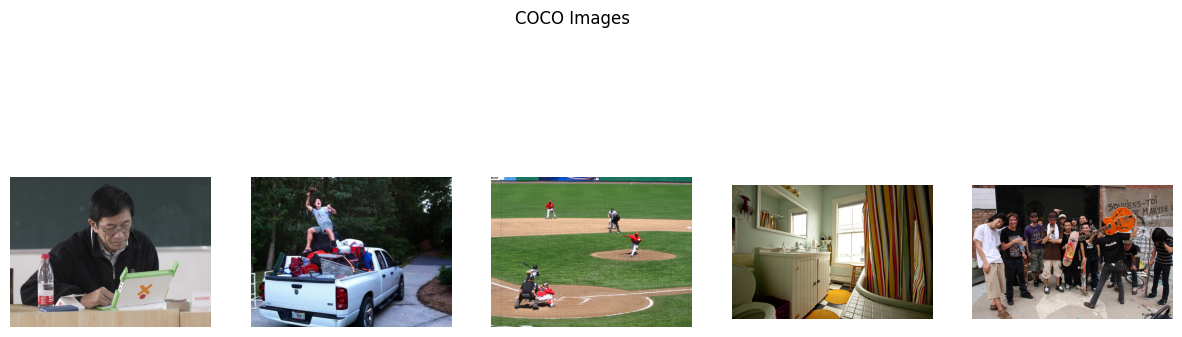

Displaying WikiArt images:


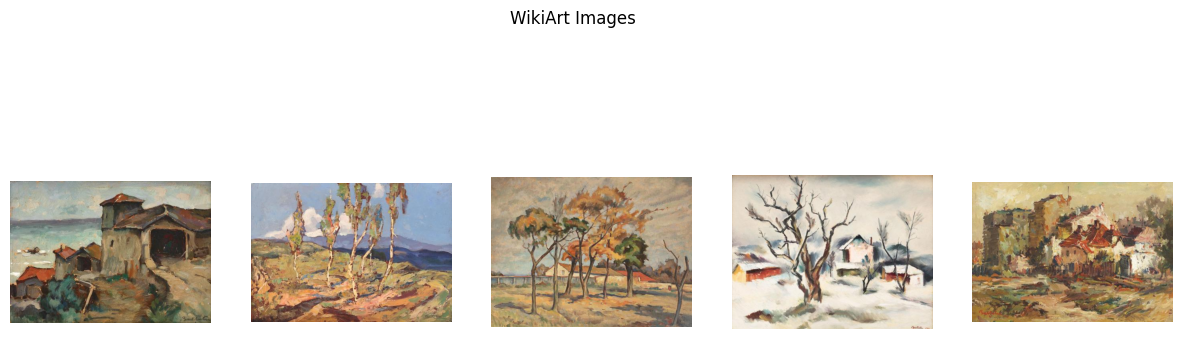

In [ ]:

# Data Preparation
# Load COCO dataset
c_train_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    dataset_name="coco-2017-train",
    shuffle=True,
    max_samples=100
)

# Extract image filepaths
c_train_image_paths = [sample.filepath for sample in c_train_dataset]

# Load WikiArt dataset
api = WikiartAPI()
artist_group = get_artist("impressionism")
files = []
for artist in artist_group:
    tmp = api.get_painting(artist)
    if tmp is not None:
        files += tmp

print("Inspecting the contents of `files`:")
print(files[:5])  # Print to understanding the structure

style_image_paths = files

print(f"Extracted {len(style_image_paths)} valid image paths.")

# Image displaying
def display_images(image_list, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(image_list))):
        plt.subplot(1, num_images, i + 1)
        if isinstance(image_list[i], str):  # Local file path
            img = mpimg.imread(image_list[i])
            plt.imshow(img)
        else:
            print(f"Unsupported type: {type(image_list[i])}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Displaying some COCO images
print("Displaying COCO images:")
display_images(c_train_image_paths, "COCO Images")

# Displaying some WikiArt images
print("Displaying WikiArt images:")
display_images(style_image_paths, "WikiArt Images")

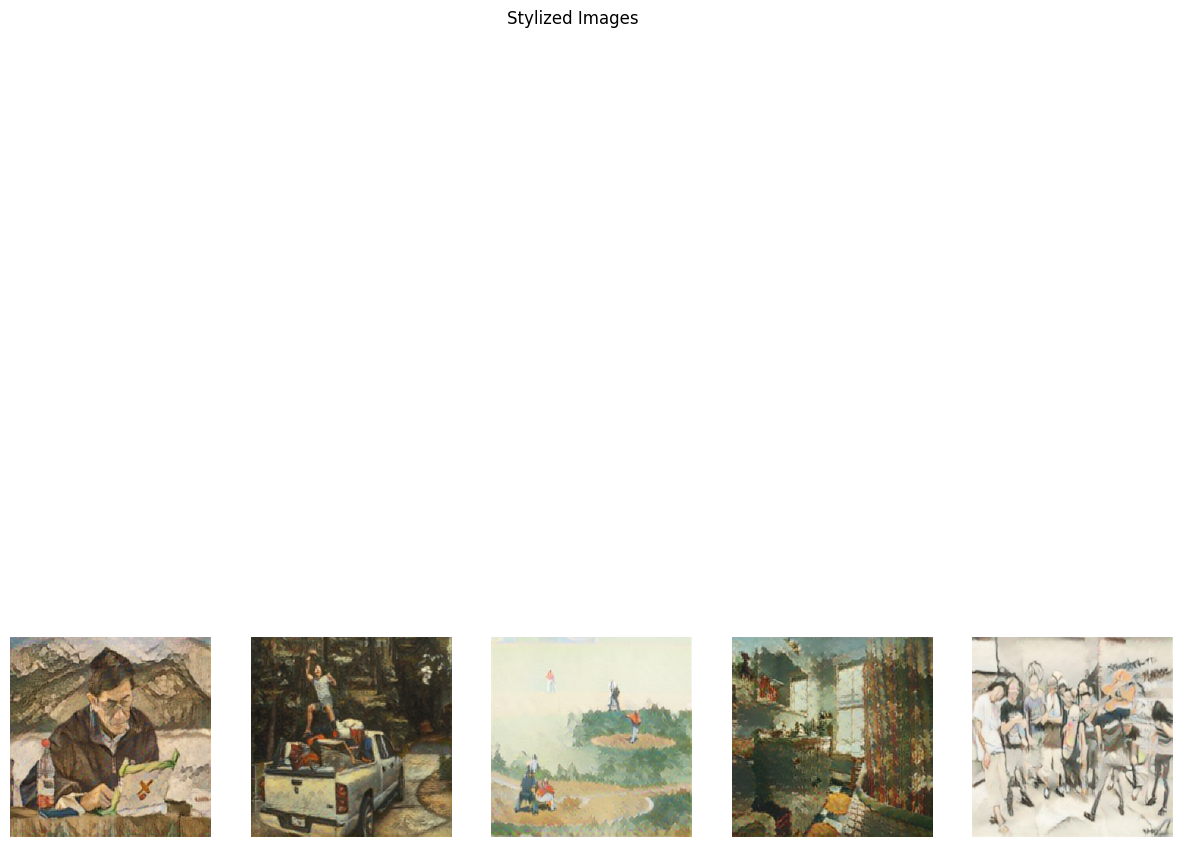

In [ ]:
# Function for loading and preprocessing images
def load_image(image_path, target_size=(256, 256)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_size)
    img = tf.expand_dims(img, axis=0)  # batch dimension
    return img

# Loading content images
content_images = [load_image(path) for path in c_train_image_paths[:40]]
# Loading style images
style_images = [load_image(path) for path in style_image_paths[:40]]

# Loading the TensorFlow Hub model for arbitrary image stylization
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')


stylized_images = []

for content_img in content_images:
    # Selecting a random style image
    style_img = style_images[np.random.randint(0, len(style_images))]

    # Apllying style transfer
    stylized_image = hub_model(content_img, style_img)[0]
    stylized_images.append(stylized_image)


def display_stylized_images(stylized_images, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(stylized_images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(stylized_images[i][0])
        plt.axis('off')
    plt.suptitle("Stylized Images")
    plt.show()

# Displaying some stylized images
display_stylized_images(stylized_images, num_images=5)


In [ ]:
# Create pairs for contrastive learning with a helper function
def create_contrastive_pairs(content_images, style_images, stylized_images):
    pairs = []
    labels = []
    num_images = len(content_images)

    # Generate positive samples: Same content image, different styles
    for i in range(num_images):
        for j in range(i + 1, num_images):
            if i != j:
                pairs.append([stylized_images[i], stylized_images[j]])
                labels.append(1)  # Positive pair

    # Generate negative samples: Different content images with the same style
    for i in range(num_images):
        for j in range(num_images):
            if i != j:
                pairs.append([stylized_images[i], stylized_images[j]])
                labels.append(0)  # Negative pair

    # Generate negative samples: Different content images with different styles
    for i in range(num_images):
        for j in range(i + 1, num_images):
            if i != j:
                pairs.append([stylized_images[i], stylized_images[j]])
                labels.append(0)  # Negative pair

    return np.array(pairs), np.array(labels)

# Being sure that using diverse samples
content_images_subset = c_train_image_paths[:20]
style_images_subset = [img[0].numpy() for img in style_images[:20]]
stylized_images_subset = np.array([img[0].numpy() for img in stylized_images[:20]])

# Creating pairs
pairs, pair_labels = create_contrastive_pairs(content_images_subset, style_images_subset, stylized_images_subset)

# Split pairs into train and test sets
pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, pair_labels, test_size=0.2, random_state=42)

print(f"Number of training pairs: {len(pairs_train)}")
print(f"Number of testing pairs: {len(pairs_test)}")
print(f"Training labels distribution: {np.bincount(labels_train)}")
print(f"Testing labels distribution: {np.bincount(labels_test)}")


Number of training pairs: 608
Number of testing pairs: 152
Training labels distribution: [452 156]
Testing labels distribution: [118  34]


Epoch 1/10
38/38 [==============================] - 373s 9s/step - loss: 0.6812 - accuracy: 0.7204 - val_loss: 0.6664 - val_accuracy: 0.7763
Epoch 2/10
38/38 [==============================] - 356s 9s/step - loss: 0.6422 - accuracy: 0.7434 - val_loss: 0.6306 - val_accuracy: 0.7763
Epoch 3/10
38/38 [==============================] - 339s 9s/step - loss: 0.6076 - accuracy: 0.7434 - val_loss: 0.6004 - val_accuracy: 0.7763
Epoch 4/10
38/38 [==============================] - 320s 8s/step - loss: 0.5908 - accuracy: 0.7434 - val_loss: 0.5939 - val_accuracy: 0.7763
Epoch 5/10
38/38 [==============================] - 365s 10s/step - loss: 0.5837 - accuracy: 0.7434 - val_loss: 0.5937 - val_accuracy: 0.7763
Epoch 6/10
38/38 [==============================] - 338s 9s/step - loss: 0.5662 - accuracy: 0.7434 - val_loss: 0.5891 - val_accuracy: 0.7763
Epoch 7/10
38/38 [==============================] - 326s 9s/step - loss: 0.5746 - accuracy: 0.7434 - val_loss: 0.5964 - val_accuracy: 0.7763
Epoch 8/10
3

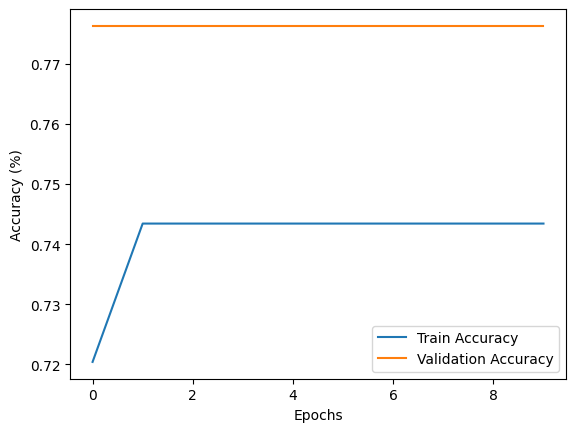

In [ ]:
# Creating the base model (MobileNetV2)
def create_base_model(input_shape):
    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Creating the Siamese Network
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)

    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    # Outputs merging with L2 distance
    l2_distance_layer = Lambda(lambda tensors: tf.norm(tensors[0] - tensors[1], axis=1, keepdims=True))
    l2_distance = l2_distance_layer([output_1, output_2])

    # Classification layer
    output = Dense(1, activation="sigmoid")(l2_distance)

    siamese_model = Model(inputs=[input_1, input_2], outputs=output)
    return siamese_model

input_shape = (256, 256, 3)
siamese_model = create_siamese_network(input_shape)

# Model compiling
siamese_model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Training
history = siamese_model.fit(
    [pairs_train[:, 0], pairs_train[:, 1]],
    labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=10,
    batch_size=16
)

# Evaluating the model
results = siamese_model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")

# Plotting the training and validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Epoch 1/10
38/38 [==============================] - 43s 992ms/step - loss: 1.1924 - accuracy: 0.6217 - val_loss: 0.7064 - val_accuracy: 0.7763
Epoch 2/10
38/38 [==============================] - 35s 927ms/step - loss: 0.6395 - accuracy: 0.7138 - val_loss: 0.5971 - val_accuracy: 0.6842
Epoch 3/10
38/38 [==============================] - 35s 933ms/step - loss: 0.6228 - accuracy: 0.7220 - val_loss: 0.5638 - val_accuracy: 0.7763
Epoch 4/10
38/38 [==============================] - 47s 1s/step - loss: 0.6280 - accuracy: 0.7089 - val_loss: 0.5162 - val_accuracy: 0.7763
Epoch 5/10
38/38 [==============================] - 40s 1s/step - loss: 0.6008 - accuracy: 0.7303 - val_loss: 0.5430 - val_accuracy: 0.7763
Epoch 6/10
38/38 [==============================] - 38s 992ms/step - loss: 0.5748 - accuracy: 0.7434 - val_loss: 0.5185 - val_accuracy: 0.7763
Epoch 7/10
38/38 [==============================] - 37s 991ms/step - loss: 0.5968 - accuracy: 0.7336 - val_loss: 0.5813 - val_accuracy: 0.7763
Epoch

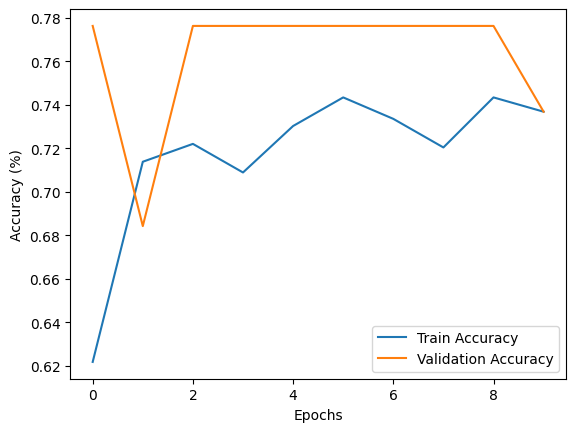

In [ ]:
# Freezing the base model
for layer in siamese_model.layers[:-1]:
    layer.trainable = False

# Creating a new model for linear classification
input_layer = Input(shape=input_shape)
features = siamese_model.layers[-3](input_layer)  # Feature extaction from the layer before the output layer
flatten_layer = Flatten()(features)
dense_layer = Dense(128, activation="relu")(flatten_layer)
output_layer = Dense(1, activation="sigmoid")(dense_layer)

linear_model = Model(inputs=input_layer, outputs=output_layer)
linear_model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])

# Training
history_linear = linear_model.fit(
    pairs_train[:, 0],
    labels_train,
    validation_data=(pairs_test[:, 0], labels_test),
    epochs=10,
    batch_size=16
)

# Evaluating the linear classifier
results_linear = linear_model.evaluate(pairs_test[:, 0], labels_test)
print(f"Linear Model Test Loss: {results_linear[0]}")
print(f"Linear Model Test Accuracy: {results_linear[1] * 100:.2f}%")

# Plotting the training and validation accuracy for the linear model
plt.plot(history_linear.history["accuracy"], label="Train Accuracy")
plt.plot(history_linear.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


In [ ]:
# Making predictions with the linear model
predictions = linear_model.predict(pairs_test[:, 0])
predictions = np.round(predictions).astype(int)

# Calculating performance metrics
accuracy = accuracy_score(labels_test, predictions) * 100
precision = precision_score(labels_test, predictions) * 100
recall = recall_score(labels_test, predictions) * 100
f1 = f1_score(labels_test, predictions) * 100
conf_matrix = confusion_matrix(labels_test, predictions)
class_report = classification_report(labels_test, predictions)

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

5/5 [==============================] - 18s 2s/step
Accuracy: 73.68%
Precision: 20.00%
Recall: 5.88%
F1 Score: 9.09%
Confusion Matrix:
[[110   8]
 [ 32   2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.85       118
           1       0.20      0.06      0.09        34

    accuracy                           0.74       152
   macro avg       0.49      0.50      0.47       152
weighted avg       0.65      0.74      0.68       152

